In [5]:
# Thư viện cần thiết
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.errors import SettingWithCopyWarning
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2, stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import joblib
import os

In [6]:
# Import Datasets
cc_data_full_data = pd.read_csv('datasets/application_record.csv')      # Thông tin ứng viên
credit_status = pd.read_csv('datasets/credit_record.csv')               # Thông tin thẻ tín dụng

## Thông tin ứng viên

In [7]:
cc_data_full_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## Thông tin thẻ tín dụng

In [8]:
credit_status.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# KHAI PHÁ VÀ PHÂN TÍCH DỮ LIỆU

## Khởi tạo biến mục tiêu:
> Dựa trên điều kiện khách hàng quá hạn 60 ngày (được gán nhãn)

In [9]:
# Tính độ tuổi tài khoản của mỗi khách hàng
begin_month = pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month = begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data = pd.merge(cc_data_full_data, begin_month, how='left', on='ID')

# Xác định khách hàng có rủi ro tín dụng cao
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] == '2'] = 'Yes'
credit_status['dep_value'][credit_status['STATUS'] == '3'] = 'Yes'
credit_status['dep_value'][credit_status['STATUS'] == '4'] = 'Yes'
credit_status['dep_value'][credit_status['STATUS'] == '5'] = 'Yes'
cpunt = credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0] = 'Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0] = 'No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data, cpunt, how='inner', on='ID')

# Cột mục tiêu "Is high risk"
cc_data_full_data['Is high risk'] = cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk'] = 1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk'] = 0
cc_data_full_data.drop('dep_value', axis=1, inplace=True)
pd.options.mode.chained_assignment = None           # Ẩn cảnh báo

C:\Users\Admin\AppData\Local\Temp\ipykernel_3216\822578242.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  begin_month = pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
C:\Users\Admin\AppData\Local\Temp\ipykernel_3216\822578242.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = 

In [10]:
cc_data_full_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [11]:
# Đổi tên thuộc tính
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

## Chuẩn bị dữ liệu huấn luyện mô hình
> Sử dụng cc_data_full_data để chia ra làm 80% tập train và 20% tập test

In [12]:
# Phân tách dữ liệu
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [13]:
# Dữ liệu tập Train và tập Test
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [14]:
# Kiểm tra số chiều của hai tập
print(f"DimTrain = {cc_train_original.shape}")
print(f"DimTest = {cc_test_original.shape}")

DimTrain = (29165, 20)
DimTest = (7292, 20)


In [15]:
# Xuất file.csv của tập train và tập test
cc_train_original.to_csv('datasets/train.csv', index = False)
cc_test_original.to_csv('datasets/test.csv', index = False)

In [16]:
# Sao chép dữ liệu train và test để làm việc
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

In [17]:
# Tổng quan dữ liệu
cc_data_full_data.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [18]:
# Thông tin chi tiết bộ dữ liệu
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [19]:
# Cung cấp thông tin thống kê
cc_data_full_data.describe()

,ID,Children count,Income,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


## Thống kê dữ liệu dạng biểu đồ
> Tìm kiếm thuộc tính mất mát thông tin

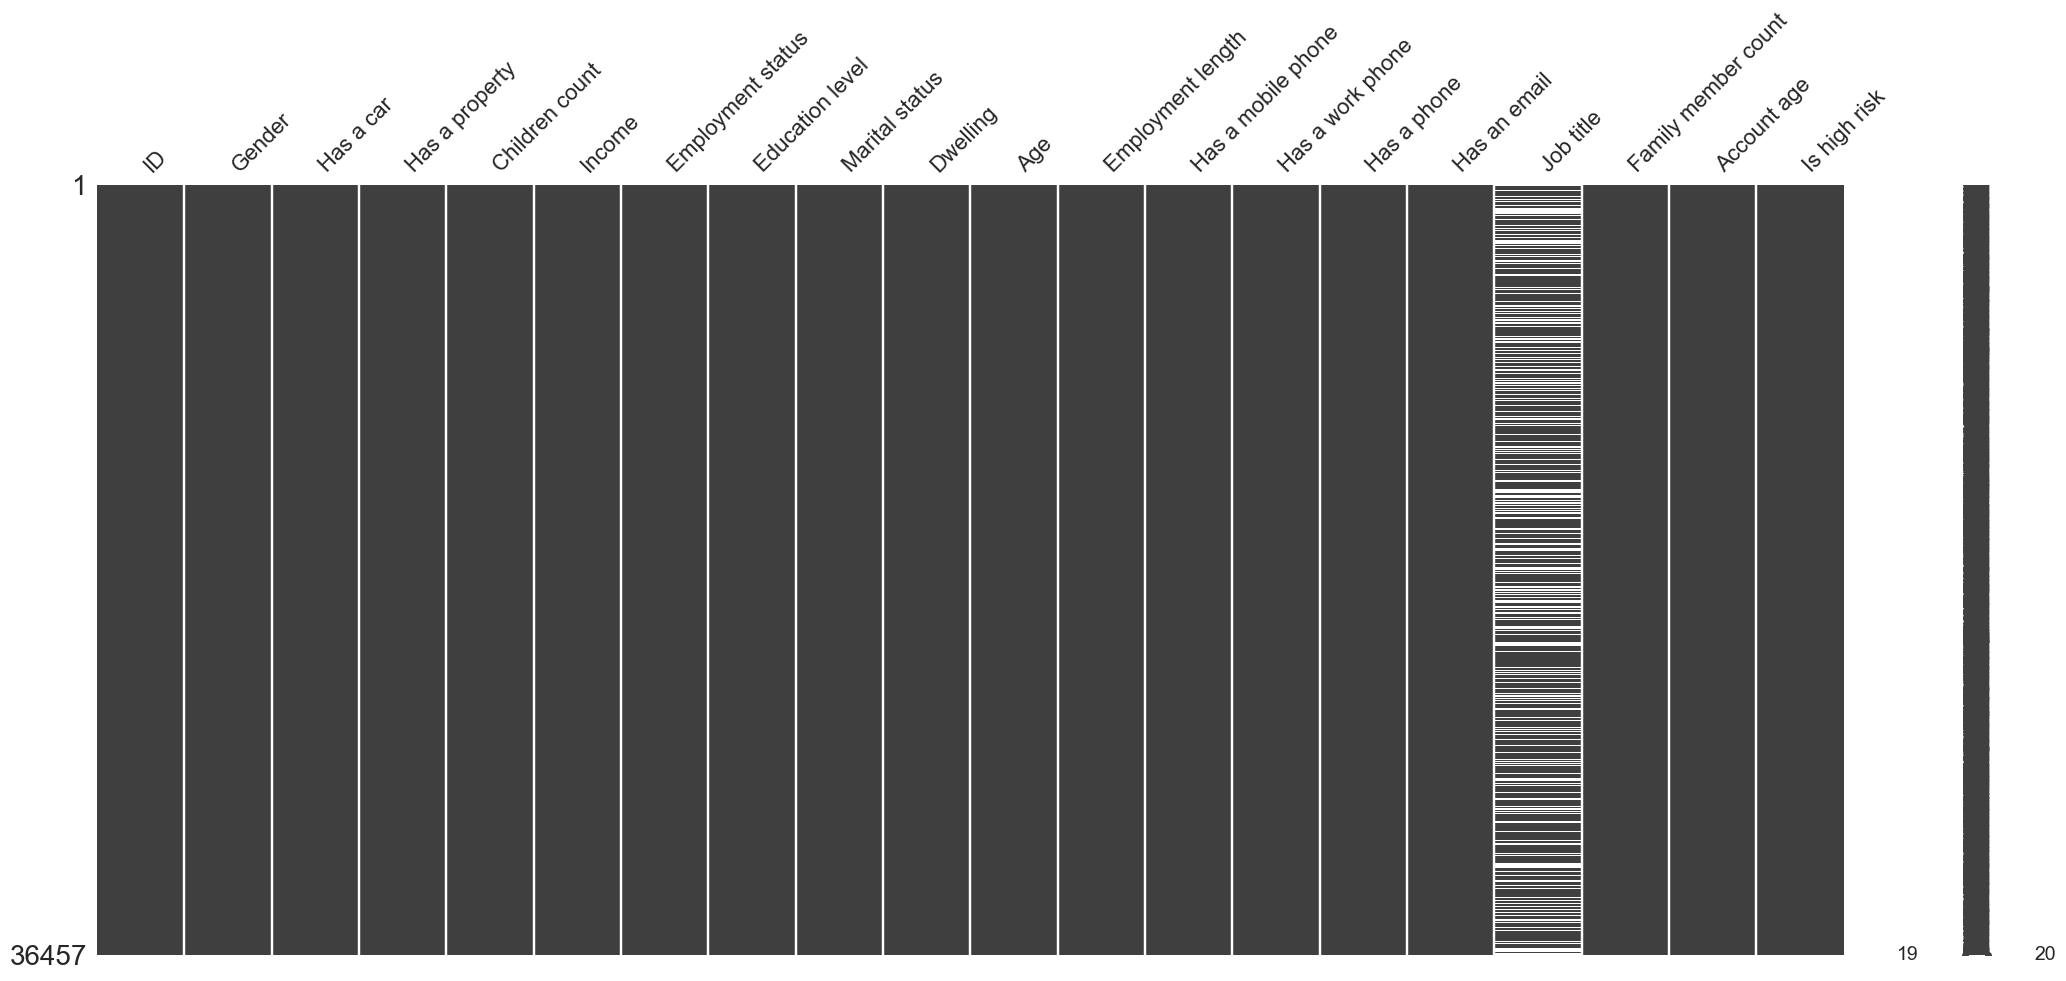

In [20]:
# Sử dụng Missingno trực quan hóa giá trị của thuộc tính (Jon title mất mát giá trị)
msno.matrix(cc_data_full_data)
plt.show()

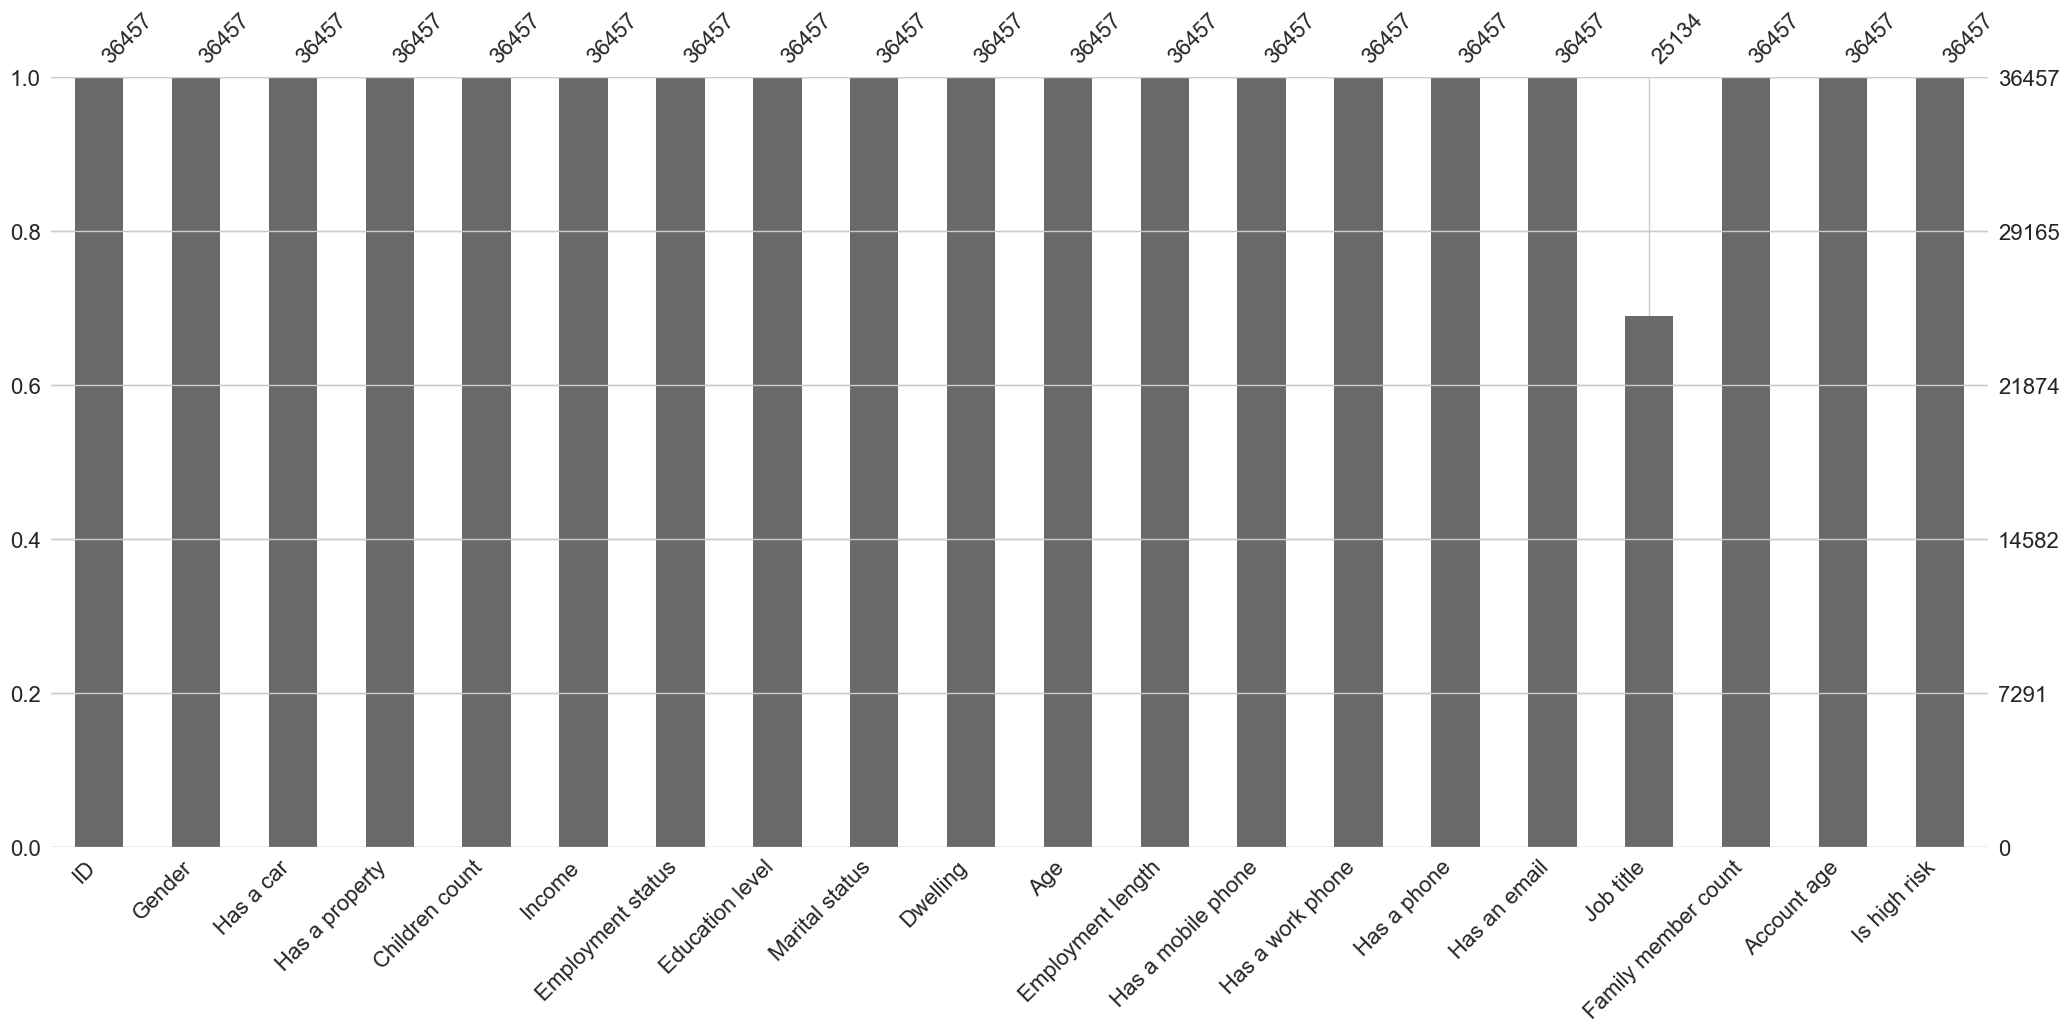

In [21]:
# Trực quan hóa dữ liệu chi tiết
msno.bar(cc_data_full_data)
plt.show()

## Phân tích dữ liệu
1. Tính số lượng và tần suất xuất hiện của đặc trưng thuộc tính

2. Mô tả thông tin dữ liệu thống kê của từng đặc trưng thuộc tính:
+ Tính số lượng của từng lớp trong một đặc trưng cùng với tần suất của nó
+ Mô tả thông tin dữ liệu thống kê của từng đặc trưng thuộc tính

3. Vẽ biểu đồ và đồ thị trực quan hóa dữ liệu:
+ Biểu đồ tròn (pie plot): trực quan hóa tỷ lệ phân bổ các lớp trong đặc trưng
+ Biểu đồ cột (bar plot): so sánh số lượng các lớp trong đặc trưng
+ Biểu đồ hộp (box plot): phân tích phân phối và các giá trị ngoại lai trong đặc trưng
+ Biểu đồ histogram (hist plot): phân tích sự phân bố các đặc trưng 

4. Phân tích đơn biến và đa biến

### Phân tích đơn biến:

In [81]:
# Thư viện cần thiết
from functions.data_analysis import gen_info_feat
from functions.draw_dataset import create_bar_plot, create_pie_plot, create_box_plot, create_hist_plot

#### Đặc trưng Gender

In [82]:
# Phân tích dữ liệu đơn biến Gender
gen_info_feat(cc_train_copy, 'Gender', cc_test_copy)

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency (%)
Gender                      
F       19549      67.028973
M        9616      32.971027


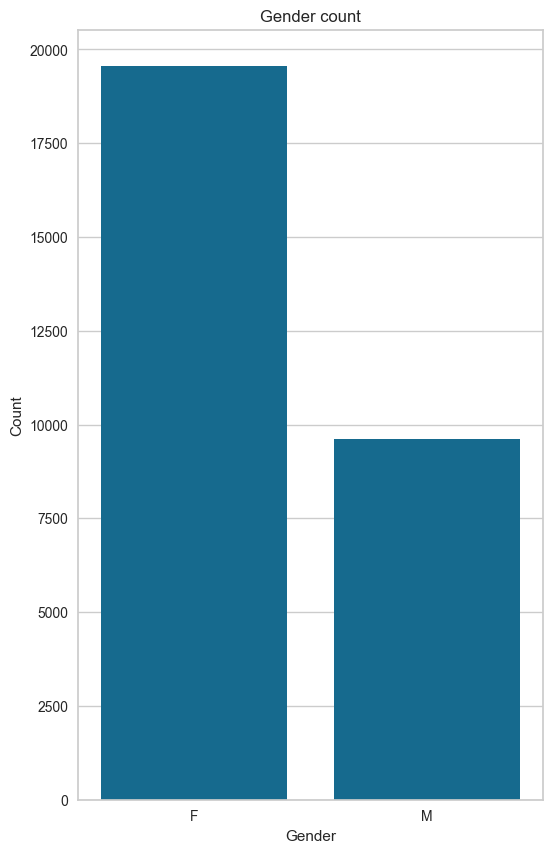

In [83]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Gender')

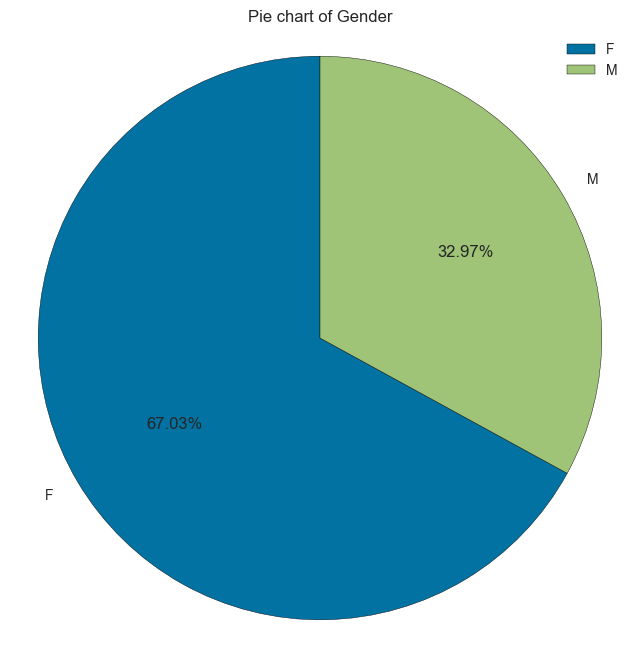

In [85]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Gender')

### Đặc trưng Age

In [86]:
# Phân tích dữ liệu đơn biến Age
gen_info_feat(cc_train_copy, 'Age', cc_test_copy)

Description:
count    29165.000000
mean        43.749425
std         11.507180
min         21.095140
25%         34.154689
50%         42.614648
75%         53.234771
max         68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64
Description:
count    29165.000000
mean    -15979.477490
std       4202.997485
min     -25152.000000
25%     -19444.000000
50%     -15565.000000
75%     -12475.000000
max      -7705.000000
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
        Count  Frequency (%)
Age                         
-15519     44       0.150866
-12676     44       0.150866
-16896     33       0.113149
-16768     26       0.089148
-16053     26       0.089148
...       ...            ...
-9235       1       0.003429
-16968      1       0.003429
-15714      1       0.003429
-10718      1       0.003429
-17757      1      

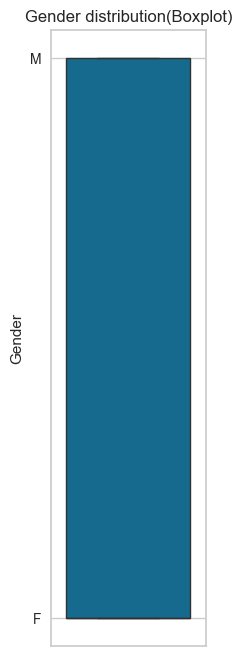

In [87]:
# Vẽ biểu đồ hộp
create_box_plot(cc_train_copy, 'Gender', cc_train_copy)

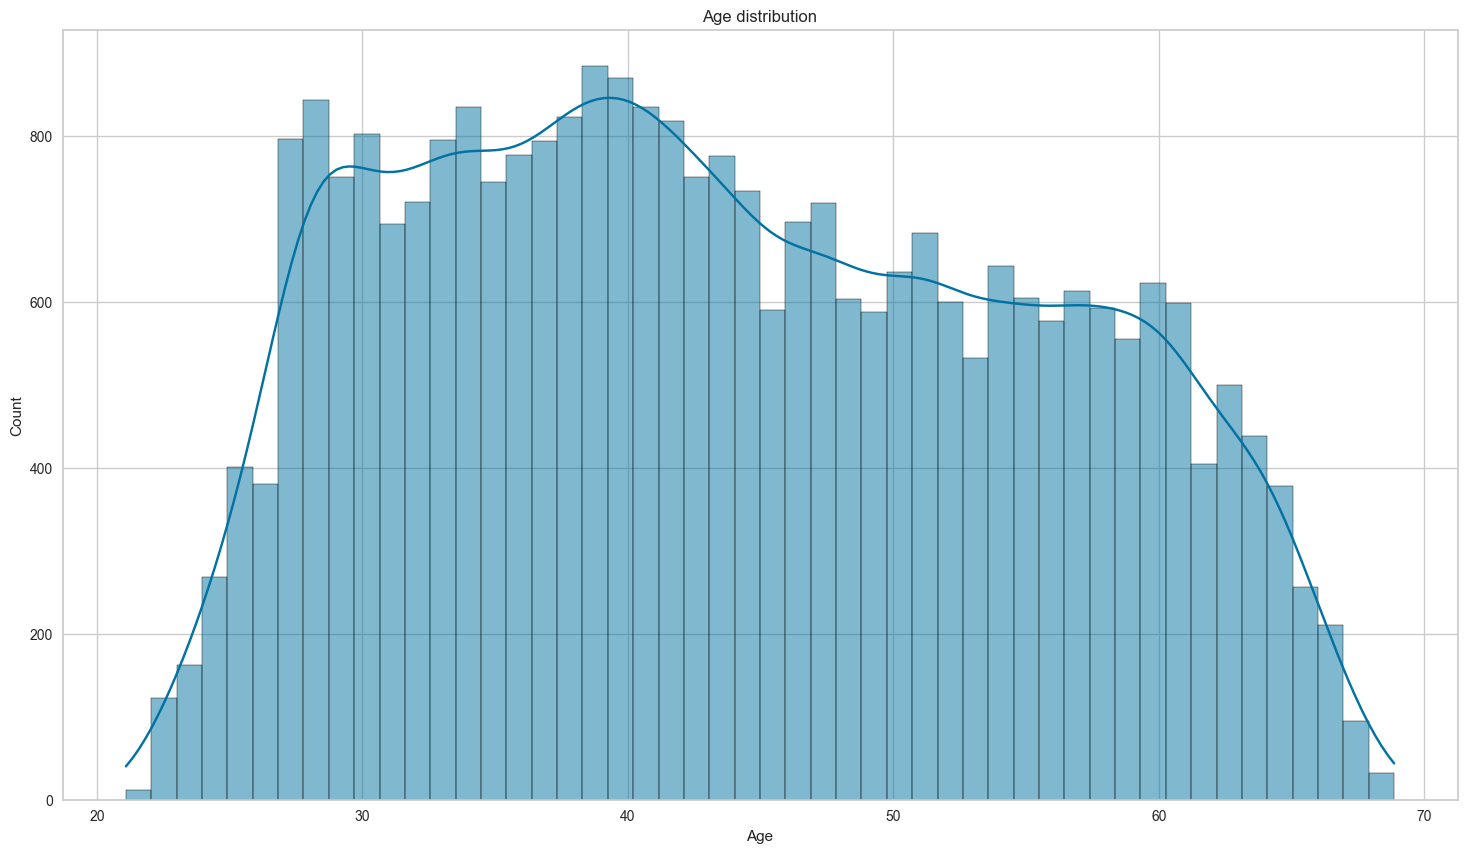

In [88]:
# Vẽ biểu đồ histogram
create_hist_plot(cc_train_copy, 'Age', cc_train_copy)